In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

#### Some helper

In [3]:
class PeriodicBasis(torch.nn.Module):
    
    def forward(self, x):
        return torch.cat([
            (2 * np.pi * x).cos(),
            (2 * np.pi * x).sin()
        ], dim=-1)

In [4]:
from bgflow import (
    DenseNet,
    
    WrapCDFTransformerWithInverse,
    GridInversion,
    AffineSigmoidComponentInitGrid,
    
    MixtureCDFTransformer,
    
    ConditionalSplineTransformer,
    AffineSigmoidComponents,   
    MoebiusComponents,
    NonCompactAffineSigmoidComponents,
    
    SmoothRamp,
    SmoothRampWithTrainableExponent,
    BisectionRootFinder,
    
    ConstrainedBoundaryCDFTransformer,
    
    SequentialFlow,
    CouplingFlow,
    SplitFlow,
    InverseFlow,
    SwapFlow,
    
)

from matplotlib.colors import LogNorm


def plot_transformer_density(transformer, label, grid_size=100):
    with torch.enable_grad():
        ys = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
        xs = torch.zeros_like(ys)
        ys_, dlogp_ = transformer(xs, ys)
        computed_density = dlogp_.exp()
        ad_density = torch.autograd.grad(ys_.sum(), ys, create_graph=True)[0]
        
        plt.figure(figsize=(10, 3))
        plt.title(label)
        plt.plot(ys.detach(), ys_.detach(), label="cdf")
        plt.plot(ys.detach(), computed_density.detach(), alpha=0.5, label="computed pdf")
        plt.plot(ys.detach(), ad_density.detach(), linestyle="--", label="AD pdf")
        plt.legend()
        
def make_net(d_in, d_hidden, d_out, activation, periodic=False, init_weight=1):
    return torch.nn.Sequential(
        PeriodicBasis() if periodic else torch.nn.Identity(),
        DenseNet([d_in * (2 if periodic else 1), d_hidden, d_hidden, d_out], activation, weight_scale=init_weight)
    )

def make_transformer(
    d_in,
    d_out,
    d_hidden,
    n_components,
    transformer_type="spline",
    inverse="approx",
    periodic=False,
    zero_boundary_left=False,
    zero_boundary_right=False,
    activation=torch.nn.SiLU(),
    smoothness_type="type1",
    init_weight=1.,
    min_density=1e-6,
    verbose=False,
    n_grid_inversion=10
):
    offset = 1 if not periodic else 0
    if transformer_type == "spline":
        t = ConditionalSplineTransformer(
            params_net=make_net(d_in, d_hidden, d_out * (n_components * 3 + offset), activation, periodic=periodic, init_weight=init_weight),
            is_circular=periodic
        )
    elif transformer_type == "bump":
        t = MixtureCDFTransformer(
                compute_weights=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                compute_components=AffineSigmoidComponents(
                    conditional_ramp=SmoothRamp(
                        compute_alpha=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                        unimodal=True,
                        ramp_type=smoothness_type
                    ),
                    log_sigma_bound=torch.tensor(1.),
                    compute_params=make_net(d_in, d_hidden, d_out * (3 * n_components), activation, periodic=periodic),
                    min_density=torch.tensor(min_density),
                    periodic=periodic,
                    zero_boundary_left=zero_boundary_left,
                    zero_boundary_right=zero_boundary_right

                ),
        )
    elif transformer_type == "sigmoid":
        t = MixtureCDFTransformer(
                compute_weights=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                compute_components=NonCompactAffineSigmoidComponents(
                    compute_params=make_net(d_in, d_hidden, d_out * n_components * 3, activation, periodic=periodic),
                    domain=torch.tensor([0. - 1e-1, 1. + 1e-1])
                )
        )
    elif transformer_type == "moebius":
        t = MixtureCDFTransformer(
                compute_weights=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                compute_components=MoebiusComponents(
                    compute_params=make_net(d_in, d_hidden, d_out * n_components * 2, activation, periodic=periodic)
                )
        )        
    else:
        raise ValueError(f"unknown transformer_type={transformer_type}")        
    if inverse=="approx":
        return WrapCDFTransformerWithInverse(
            transformer=t,        
            oracle=GridInversion(
                transformer=t,
                compute_init_grid=lambda x,y: torch.linspace(0, 1, n_grid_inversion, device=y.device, dtype=y.dtype).view(-1, 1, 1).repeat(1, *y.shape),
                verbose=verbose,
                abs_tol=1e-6
            )
        )
    elif inverse=="exact":
        return t
    else:
        raise ValueError(f"unknown inverse={inverse}")


def make_coupling_flow(transformer_factory):    
    return SequentialFlow([
        SplitFlow(1),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        InverseFlow(SplitFlow(1))
    ])

In [5]:
def gauss(_r, r0, sigma):
    return torch.exp(-(_r-r0)**2/(2*sigma**2))

def potential(xs):
    x, y = xs.T
    x = 2*np.pi*x  - np.pi
    y = 2*np.pi*y - np.pi
    cx = 0.0
    cy = 0.0
    r = torch.sqrt((x-cx)**2 + (y-cy)**2)
    sigma = 0.06
    return -torch.log(
        (
        gauss(r, 1.0, sigma) 
        + 
        0.8 * gauss(r, 2.0, sigma) 
        +
        0.6 * gauss(r, 1.5, sigma) 
        + 
        0.4 * gauss(r, 2.5, sigma)
        )
    )


def train(flow, train_with_inverse=False, batch_size=1_000, learning_rate=5e-4, n_iters=4_000, print_interval=100, cuda=False):
    data = np.load("2dsamples.npy")
    idxs = np.arange(len(data))
    optim = torch.optim.Adam(flow.parameters(), lr=learning_rate)
    for it in range(n_iters):
        np.random.shuffle(idxs)
        x = data[idxs[:batch_size]]
        x = torch.FloatTensor(x) 
        if cuda:
            x = x.cuda()
        y, dlogp = flow(x, inverse=train_with_inverse)    
        nll = -dlogp.mean()    
        optim.zero_grad()
        nll.backward()
        optim.step()
        if not it % print_interval:            
            print(f"it: {it}/{n_iters}, nll: {nll.item():.4}", end="\r")

def plot_forces(flow=None, energy=None, train_with_inverse=False, n_samples=100_000, norm=None, cuda=False, eps=0., save_as=None):
    
    grid_size_u = 100
    
    x1 = torch.linspace(0 - eps, 1 + eps, grid_size_u)
    x2 = torch.linspace(0 - eps, 1 + eps, grid_size_u)
    xsmeshu = torch.meshgrid(
        x1,
        x2
    )
    xsu = torch.stack(xsmeshu, dim=-1).view(-1, 2).clamp(1e-4, 1-1e-4)
    xsu = xsu.requires_grad_(True)
    
    grid_size_f = 100
    
    x1 = torch.linspace(0 - eps, 1 + eps, grid_size_f)
    x2 = torch.linspace(0 - eps, 1 + eps, grid_size_f)
    xsmeshf = torch.meshgrid(
        x1,
        x2
    )
    xsf = torch.stack(xsmeshf, dim=-1).view(-1, 2).clamp(1e-4, 1-1e-4)
    xsf = xsf.requires_grad_(True)
    
    data = np.load("2dsamples.npy")
    idxs = np.arange(len(data))
    np.random.shuffle(idxs)
    xsf = torch.FloatTensor(data).requires_grad_(True)[idxs[:5000]]
    
    if energy:
        u = energy(xsu)
        if cuda:
            xs = xs.cuda()
        fs = torch.autograd.grad(-energy(xsf).sum(), xsf)[0]
    
    if flow:

        print("Computing force plot...")
        
        ys, dlogp = flow(xsf, inverse=train_with_inverse)
        fs = torch.autograd.grad(-dlogp.sum(), xsf)[0]
        ys, dlogp = flow(xsu, inverse=train_with_inverse)
        u = -dlogp

 
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    u = u.cpu().detach().numpy().reshape(grid_size_u, grid_size_u)
    plt.imshow(np.exp(-u).T, origin="lower", aspect='auto', norm=norm)
    plt.xticks([])
    plt.yticks([])
    
    fnorm = fs.norm(dim=-1, keepdim=True)
    
    xsf = xsf.cpu().detach().numpy()
    extent = [
        np.min(xsf[:, 0]),
        np.max(xsf[:, 0]),
        np.min(xsf[:, 1]),
        np.max(xsf[:, 1]),
    ]
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 2, 2)
    Q = plt.quiver(xsf[:, 0], xsf[:, 1], fs[:, 0], fs[:, 1], scale_units='x', scale=10000)
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


    if save_as:
        plt.savefig(f"{save_as}.pdf")

processing spline_nonperiodic
Computing force plot...2747
processing bump_nonperiodic
Computing force plot...337


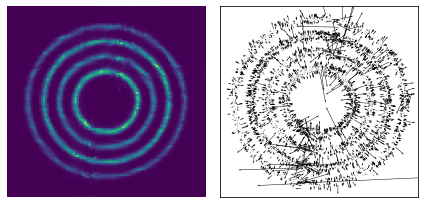

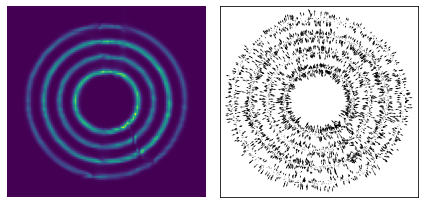

In [6]:
from functools import partial

is_periodic = False
load = False

from matplotlib.colors import PowerNorm
norm=None

for ttype in ["spline", "bump"]:
    
    if is_periodic and ttype == "sigmoid":
        continue
    if not is_periodic and ttype == "moebius":
        continue
    
    if ttype == "moebius":
        periodic = True
    if ttype == "sigmoid":
        periodic = False
    else:
        periodic = is_periodic
        
    periodic_string = "periodic" if periodic else "nonperiodic"
    eps = 0. if periodic else 0.
    
    print(f"processing {ttype}_{periodic_string}")

    flow = make_coupling_flow(partial(make_transformer, d_in=1, d_out=1, d_hidden=100, n_components=40, periodic=periodic, verbose=False, transformer_type=ttype))

    flow = flow.cuda()
    
    if not load:
        train(flow, cuda=True, train_with_inverse=False, n_iters=8_000)
        torch.save(flow.state_dict(), f"{ttype}_{periodic_string}_flow.pt")
    else:
        state_dict = torch.load(f"{ttype}_{periodic_string}_flow.pt")
        flow.load_state_dict(state_dict)

    flow = flow.cpu()
    plot_forces(flow, energy=potential, cuda=False, save_as=f"{ttype}_{periodic_string}", eps=eps, norm=norm)

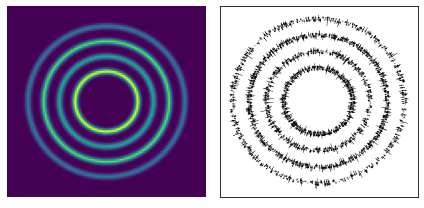

In [7]:
plot_forces(energy=potential, cuda=False, save_as=f"ground_truth", eps=0, norm=norm)